# Detector de plagio en código fuente (archivos .java)
Este notebook presenta el desarrollo de un modelo para detectar plagio en archivos de código fuente escritos en Java. Se utiliza el dataset "conplag", ubicado en   `dataset/versions/b_plag_version_2`, el cual contiene carpetas con archivos originales y versiones plagiadas.

## Objetivo
Desarrollar una herramienta híbrida automatizada que detecte plagio en código fuente, combinando análisis léxico (tokenización) y técnicas de aprendizaje automático. El objetivo es alcanzar una precisión superior al 80% en la clasificación de código como plagiado o no plagiado.

## Importación de librerías
Se importan las librerías necesarias para el procesamiento de archivos, tokenización de código Java, manipulación de datos y desarrollo del modelo de machine learning

In [30]:
import os
import random
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pygments import lex
from pygments.lexers import JavaLexer
from pygments.token import Token

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Definición de rutas
Se definen las rutas base para acceder al dataset y a los archivos de etiquetas

In [2]:
ROOT = Path().cwd().parent
BASE_PATH = ROOT / "dataset" / "versions" / "bplag_version_2"
LABELS_PATH = ROOT / "dataset" / "versions" / "labels.csv"

## Lectura de archivos .java
La función read_java_files() se encarga de recorrer recursivamente la estructura del dataset y leer el contenido de todos los archivos .java. Devuelve una lista con los identificadores de cada entrega y su respectivo código fuente.

In [3]:
def read_java_files(base_path):
    """
    Recursively reads all .java files from the given base path.
    
    Args:
        base_path (str): Path to the base directory containing submission pairs.
    
    Returns:
        data (list): List of tuples (submission_id, code_content).
    """
    data = []
    
    for submission_pair in os.listdir(base_path):
        pair_path = os.path.join(base_path, submission_pair)
        
        if os.path.isdir(pair_path):
            for submission_id in os.listdir(pair_path):
                submission_path = os.path.join(pair_path, submission_id)
                
                if os.path.isdir(submission_path):
                    for file in os.listdir(submission_path):
                        if file.endswith('.java'):
                            file_path = os.path.join(submission_path, file)
                            with open(file_path, 'r', encoding='utf-8') as f:
                                code = f.read()
                                data.append((submission_id, code))
    
    return data

In [4]:
java_files_data = read_java_files(BASE_PATH)

print(f"Total submissions loaded: {len(java_files_data)}")
print("\nFirst 2 submissions loaded:")
for submission_id, code in java_files_data[:2]:
    print(f"Submission ID: {submission_id}\nCode snippet:\n{code[:300]}...\n")

Total submissions loaded: 1822

First 2 submissions loaded:
Submission ID: 0017d438
Code snippet:
import java.io.BufferedReader;
import java.io.DataInputStream;
import java.io.IOException;
import java.io.InputStreamReader;
import java.util.*;
public class Main {
    static int modulo=998244353;
    public static void main(String[] args) {
       
        FastScanner in = new FastScanner();
     ...

Submission ID: 9852706b
Code snippet:
import java.io.BufferedReader;
import java.io.IOException;
import java.io.InputStreamReader;
import java.io.PrintWriter;
import java.util.*;

public class A {
    static List<Integer> [] adj;
    static ArrayList<Integer> temp;
    static int mod = (int) 1e9+7;
    static boolean[] vis = new boolean...



## Extracción de tokens

Para esta sección se utiliza la librería Pygments como analizador léxico. Esta librería permite extraer los tokens de un código fuente y clasificarlos en diferentes categorías. En este caso, se utilizará para extraer los tokens de código fuente en Java.

In [5]:
def extract_tokens(code):
    """
    Extracts tokens from the given Java code using Pygments.
    
    Args:
        code (str): Java code as a string.
        
    Returns:
        tokens (list): List of tokens extracted from the code.
    """
    lexer = JavaLexer()
    tokens = []
    for ttype, value in lex(code, lexer):
        if ttype in Token.Name or ttype in Token.Keyword or ttype in Token.Operator:
            val = value.strip()
            if val:
                tokens.append(f"{ttype.__class__.__name__}:{val}")
    return " ".join(tokens)

## Preparación de los datos y etiquetas
Se cargan las etiquetas desde el archivo labels.csv y se construye un diccionario para acceder fácilmente al veredicto (si un archivo es plagio o no) entre pares de entregas.

Luego, se recorren los datos de código Java en pares, extrayendo los tokens de cada archivo y concatenándolos como una sola representación textual del par. 

Paralelamente, se asigna la etiqueta correspondiente (plagiado o no) a cada par utilizando el diccionario previamente generado.

Este proceso genera dos listas:

- token_pairs: Representación textual de los pares de código.

- labels: Etiquetas binarias que indican si el par es plagiado.

In [6]:
labels_df = pd.read_csv(LABELS_PATH)

labels_dict = {}
for _, row in labels_df.iterrows():
    key = (row['sub1'], row['sub2'])
    labels_dict[key] = row['verdict']

token_pairs = []
labels = []

for i in range(0, len(java_files_data), 2):
    try:
        id1, code1 = java_files_data[i]
        id2, code2 = java_files_data[i+1]
    except IndexError:
        break
        
    t1 = extract_tokens(code1)
    t2 = extract_tokens(code2)
    token_pairs.append(f"{t1} {t2}")
    
    if (id1, id2) in labels_dict:
        labels.append(labels_dict[(id1, id2)])
    elif (id2, id1) in labels_dict:
        labels.append(labels_dict[(id2, id1)])
    else:
        print(f"Warning: No label found for pair ({id1}, {id2})")
        labels.append(0) 
        

## Data Augmentation

Debido a que nuestro dataset original contenía menos de 1000 pares de código, el modelo tenía una exposición limitada a ejemplos variados, lo que afectaba negativamente su capacidad de generalización y su rendimiento predictivo. Para mitigar este problema, implementamos una estrategia de aumento de datos que multiplicó el tamaño del conjunto original por 3 veces.

La función augment_token_sequence() permite generar nuevas versiones sintéticas de los pares de tokens aplicando pequeñas modificaciones controladas, lo que introduce variabilidad sin alterar significativamente la lógica del código original. Estas son las técnicas utilizadas:

- Shuffle: Mezcla aleatoriamente grupos de tokens dentro de una ventana, simulando cambios menores en el orden del código que pueden aparecer en plagios.

- Drop: Elimina tokens no críticos de forma aleatoria, simulando la omisión intencional de fragmentos para disimular el plagio.

- Duplicate: Duplica tokens aleatoriamente para emular redundancias introducidas deliberadamente por quien plagia.

- Synonym: Sustituye variables por sinónimos simulados (e.g., i por index), representando un cambio común en plagios superficiales.

Estas transformaciones ayudan a enriquecer el entrenamiento del modelo, exponiéndolo a variaciones más realistas en los datos y mejorando su capacidad para identificar plagio con mayor precisión.

La función generate_augmented_pairs() une los nuevos pares de tokens generados por la aumentación y les asigna las etiquetas correspondientes.

In [7]:
def augment_token_sequence(tokens, augmentation_method='shuffle', ratio=0.1):
    """
    Augments a token sequence using various methods.
    
    Args:
        tokens (str): The token sequence string to be augmented.
        augmentation_method (str): The method to use for augmentation.
            'shuffle': Randomly shuffles some tokens within a window.
            'drop': Randomly drops some tokens.
            'duplicate': Duplicates some tokens.
            'synonym': Replaces some tokens with synonyms (simulated).
        ratio (float): The percentage of tokens to modify (0.0 to 1.0).
    
    Returns:
        str: The augmented token sequence as a string.
    """
    token_list = tokens.split()
    total_tokens = len(token_list)
    num_to_modify = max(1, int(total_tokens * ratio))
    
    augmented_tokens = token_list.copy()
    
    if augmentation_method == 'shuffle':
        for _ in range(num_to_modify // 2): 
            window_size = random.randint(2, 4) 
            if total_tokens <= window_size:
                continue
                
            start_idx = random.randint(0, total_tokens - window_size)
            window = augmented_tokens[start_idx:start_idx + window_size]
            random.shuffle(window)
            augmented_tokens[start_idx:start_idx + window_size] = window
    
    elif augmentation_method == 'drop':
        critical_tokens = ['_TokenType:public', '_TokenType:class', '_TokenType:import', '_TokenType:static', '_TokenType:void', '_TokenType:main']
        indices_to_drop = []
        
        for _ in range(num_to_modify):
            valid_indices = [i for i, token in enumerate(augmented_tokens) 
                            if token not in critical_tokens and i not in indices_to_drop]
            if not valid_indices:
                break
            idx = random.choice(valid_indices)
            indices_to_drop.append(idx)
        
        augmented_tokens = [token for i, token in enumerate(augmented_tokens) if i not in indices_to_drop]
    
    elif augmentation_method == 'duplicate':
        for _ in range(num_to_modify):
            if not augmented_tokens:
                break
            idx = random.randint(0, len(augmented_tokens) - 1)
            augmented_tokens.insert(idx, augmented_tokens[idx])
    
    elif augmentation_method == 'synonym':
        variable_prefixes = ['_TokenType:i', '_TokenType:j', '_TokenType:k', '_TokenType:n', '_TokenType:m', '_TokenType:x', '_TokenType:y']
        synonym_mapping = {
            '_TokenType:i': ['_TokenType:idx', '_TokenType:index', '_TokenType:i'],
            '_TokenType:j': ['_TokenType:jdx', '_TokenType:j'],
            '_TokenType:k': ['_TokenType:kdx', '_TokenType:key', '_TokenType:k'],
            '_TokenType:n': ['_TokenType:num', '_TokenType:size', '_TokenType:n'],
            '_TokenType:m': ['_TokenType:max', '_TokenType:m'],
            '_TokenType:x': ['_TokenType:xVal', '_TokenType:x'],
            '_TokenType:y': ['_TokenType:yVal', '_TokenType:y']
        }
        
        for _ in range(num_to_modify):
            variable_indices = [i for i, token in enumerate(augmented_tokens) 
                               if any(token.startswith(prefix) for prefix in variable_prefixes)]
            if not variable_indices:
                break
                
            idx = random.choice(variable_indices)
            token = augmented_tokens[idx]
            
            matching_prefix = next((prefix for prefix in variable_prefixes if token.startswith(prefix)), None)
            if matching_prefix and matching_prefix in synonym_mapping:
                augmented_tokens[idx] = random.choice(synonym_mapping[matching_prefix])
    
    return ' '.join(augmented_tokens)

In [8]:
def generate_augmented_pairs(token_pairs, labels, augmentation_factor=2):
    """
    Generates augmented token pairs and corresponding labels.
    
    Args:
        token_pairs (list): Original token pairs.
        labels (list): Original labels.
        augmentation_factor (int): Number of augmentations per original sample.
        
    Returns:
        tuple: (augmented_pairs, augmented_labels)
    """
    augmentation_methods = ['shuffle', 'drop', 'duplicate', 'synonym']
    augmented_pairs = []
    augmented_labels = []
    
    for pair, label in zip(token_pairs, labels):
        augmented_pairs.append(pair)
        augmented_labels.append(label)
        
        parts = pair.split(' ', 1)
        if len(parts) < 2:
            continue  
        
        token_seq1, token_seq2 = parts
        
        for _ in range(augmentation_factor):
            method1 = random.choice(augmentation_methods)
            method2 = random.choice(augmentation_methods)
            
            aug_seq1 = augment_token_sequence(token_seq1, method1, ratio=0.1)
            aug_seq2 = augment_token_sequence(token_seq2, method2, ratio=0.1)
            
            augmented_pair = f"{aug_seq1} {aug_seq2}"
            
            augmented_pairs.append(augmented_pair)
            augmented_labels.append(label)
    
    return augmented_pairs, augmented_labels

In [9]:
print(f"Original dataset size: {len(token_pairs)}")
augmented_token_pairs, augmented_labels = generate_augmented_pairs(token_pairs, labels, augmentation_factor=2)
print(f"Augmented dataset size: {len(augmented_token_pairs)}")

original_unique, original_counts = np.unique(labels, return_counts=True)
augmented_unique, augmented_counts = np.unique(augmented_labels, return_counts=True)

print(f"\nOriginal class distribution:")
for label, count in zip(original_unique, original_counts):
    print(f"Label {label}: {count} samples ({count/len(labels)*100:.2f}%)")

print(f"\nAugmented class distribution:")
for label, count in zip(augmented_unique, augmented_counts):
    print(f"Label {label}: {count} samples ({count/len(augmented_labels)*100:.2f}%)")

Original dataset size: 911
Augmented dataset size: 2733

Original class distribution:
Label 0: 660 samples (72.45%)
Label 1: 251 samples (27.55%)

Augmented class distribution:
Label 0: 1980 samples (72.45%)
Label 1: 753 samples (27.55%)


## Vectorización de Datos
Una vez generadas las secuencias de tokens (originales y aumentadas), el siguiente paso es transformar estos textos en representaciones numéricas que puedan ser utilizadas por algoritmos de aprendizaje automático. Para ello, empleamos la técnica TF-IDF (Term Frequency–Inverse Document Frequency), que asigna pesos a cada token en función de su frecuencia en un documento.

La función vectorize() se encarga de convertir los pares de tokens en una matriz dispersa, donde cada fila representa una instancia y cada columna una característica (token). Esta representación es fundamental para que el modelo pueda aprender patrones a partir del contenido del código fuente.

En esta etapa se utilizó el conjunto de datos aumentado para asegurar una mejor cobertura léxica durante el proceso de vectorización.

In [10]:
def vectorize(token_pairs):
    """
    Vectorizes the given token pairs using TF-IDF.
    
    Args:
        token_pairs (list): List of tokens to be vectorized.
    
    Returns:
        vectorizer (TfidfVectorizer): Fitted TF-IDF vectorizer.
        X (sparse matrix): TF-IDF matrix of the token pairs.
    """
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(token_pairs)
    return vectorizer, X

In [11]:
vectorizer, X = vectorize(augmented_token_pairs)
Y = augmented_labels

In [12]:
print(f"X shape: {X.shape}")

X shape: (2733, 2460)


## Separación del Conjunto de Datos y Balanceo de Clases
Antes de entrenar el modelo, se transformó la matriz TF-IDF dispersa a una representación densa (X_dense) para su uso en ciertos algoritmos que no aceptan matrices dispersas.

Posteriormente, el conjunto de datos fue dividido en entrenamiento y prueba utilizando muestreo estratificado, lo cual garantiza que la distribución de clases (por ejemplo, plagio vs. no plagio) se mantenga proporcional en ambos subconjuntos. Esto es crucial cuando se trabaja con clases desbalanceadas.

A pesar de esto, el conjunto de entrenamiento seguía mostrando un desbalance significativo, por lo que se aplicó SMOTE (Synthetic Minority Over-sampling Technique). Esta técnica genera ejemplos sintéticos de la clase minoritaria a partir de instancias existentes, incrementando así su representación sin necesidad de duplicar ejemplos reales. El resultado fue un conjunto de entrenamiento balanceado, lo cual mejora la capacidad del modelo para aprender correctamente ambas clases.

In [13]:
X_dense = X.toarray()

X_train, X_test, y_train, y_test = train_test_split(
    X_dense, Y, test_size=0.2, random_state=42, stratify=Y)

In [14]:
unique, counts = np.unique(y_train, return_counts=True)
print(f"Training set class distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples ({count/len(y_train)*100:.2f}%)")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_train_resampled, return_counts=True)
print(f"\nResampled training set class distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples ({count/len(y_train_resampled)*100:.2f}%)")

Training set class distribution:
Label 0: 1584 samples (72.46%)
Label 1: 602 samples (27.54%)

Resampled training set class distribution:
Label 0: 1584 samples (50.00%)
Label 1: 1584 samples (50.00%)


## Función para calcular la matriz de confusión
Esta función calcula la cantidad de True Positives (TP), True Negatives (TN), False Positives (FP) y False Negatives (FN). A partir de estas tasas de predicciones correctas e incorrectas podemos calcular las métricas de F1, precision y recall, lo cual nos dará un mejor output sobre el ajuste y rendimiento predictivo del modelo.

## Función  para evaluar el modelo
Declaración de la función evaluate_model para evaluar al modelo una vez terminado el entrenamiento para ver su capacidad predictiva con datos que no fueron vistos durante el entrenamiento. Al terminar la evaluación obtenemos las métricas (precision, recall, f1 y accuracy) para determinar el ajuste y rendimiento del modelo.

In [39]:
def evaluate_model(name, model, X_test, y_test):
    """
    Evaluates model performance and returns metrics.
    
    Args:
        name (str): Model name for display purposes.
        model: Trained model to evaluate.
        X_test: Test features.
        y_test: True labels.
        
    Returns:
        dict: Dictionary with accuracy, precision, recall, and f1 metrics.
    """
    
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(9, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True,
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix | {name}')
    plt.show()
    
    print(classification_report(y_test, y_pred))


## Definición del modelo y entrenamiento
Para encontrar la mejor arquitectura que se adecúe a la problemática, hemos decidido utilizar tres arquitecturas diferentes con el fin de comparar sus métricas y así tener la suficiente información como para tomar una decisión basada en los datos. Para identificar el modelo más adecuado al problema de detección de plagio, se entrenaron y compararon los siguientes clasificadores:

- Logistic Regression (LR): Modelo lineal utilizado para clasificación binaria. Calcula la probabilidad de pertenencia a una clase usando la función sigmoide. Es sencillo, rápido y efectivo para problemas linealmente separables.

- Random Forest (RF): Ensamble de múltiples árboles de decisión entrenados sobre diferentes subconjuntos del conjunto de datos. Es robusto, reduce el sobreajuste y suele ofrecer un buen rendimiento general en tareas de clasificación.

- Multi-layer Perceptron (MLP): Red neuronal completamente conectada con al menos una capa oculta. Puede modelar relaciones no lineales complejas entre características y clases. En este caso, se utiliza una arquitectura básica con una sola capa oculta de 100 neuronas y función de activación ReLU.

In [35]:
lr_model = LogisticRegression()

rf_model = RandomForestClassifier()

mlp_model = MLPClassifier(hidden_layer_sizes=(100,), 
                          activation='relu',          
                          solver='adam',             
                          max_iter=300,              
                          random_state=42)            


In [36]:
base_models = [
    ('LR', lr_model),
    ('RF', rf_model),
    ('MLP', mlp_model),
]

In [37]:
results = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
}


Evaluación de LR


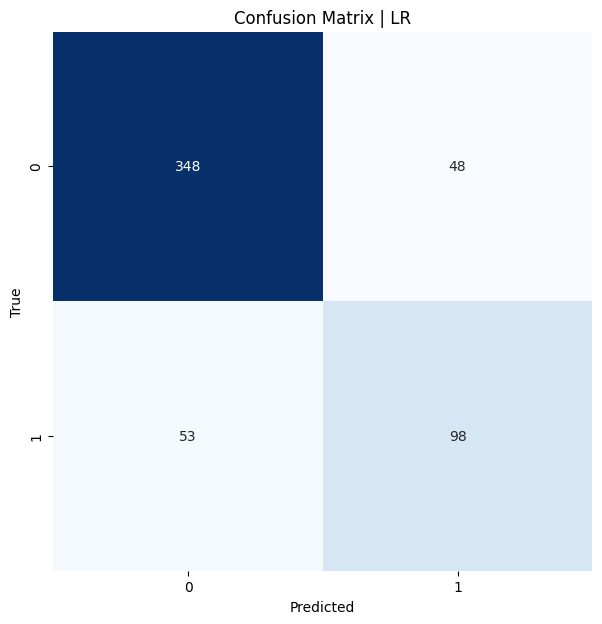

              precision    recall  f1-score   support

           0       0.87      0.88      0.87       396
           1       0.67      0.65      0.66       151

    accuracy                           0.82       547
   macro avg       0.77      0.76      0.77       547
weighted avg       0.81      0.82      0.81       547


Evaluación de RF


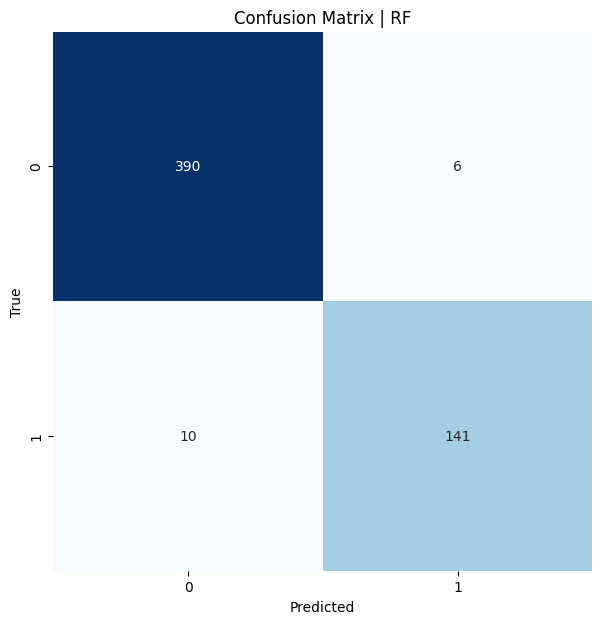

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       396
           1       0.96      0.93      0.95       151

    accuracy                           0.97       547
   macro avg       0.97      0.96      0.96       547
weighted avg       0.97      0.97      0.97       547


Evaluación de MLP


c:\Users\david\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


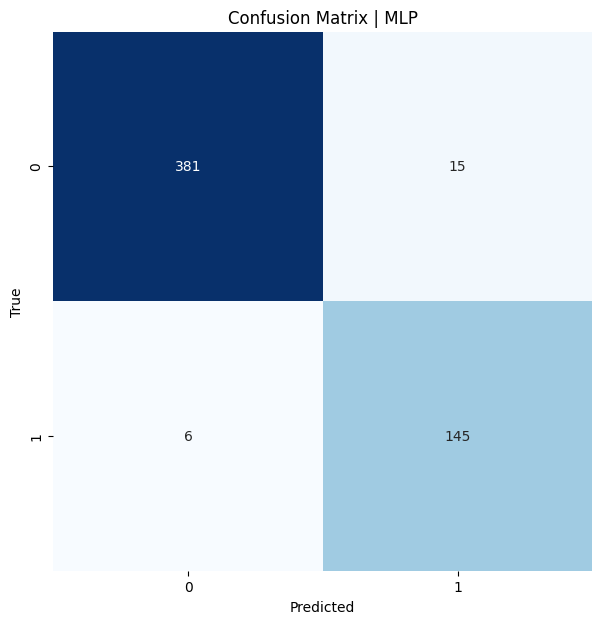

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       396
           1       0.91      0.96      0.93       151

    accuracy                           0.96       547
   macro avg       0.95      0.96      0.95       547
weighted avg       0.96      0.96      0.96       547



In [40]:
for name, model in base_models:
    print(f"\nEvaluación de {name}")
    model.fit(X_train_resampled, y_train_resampled)
    evaluate_model(name, model, X_test, y_test)